# Train a tiny synthetic yield model
This notebook creates a synthetic dataset and fits a RandomForest to show improved predictions.

In [ ]:
import numpy as np, pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

np.random.seed(42)
N = 200

df = pd.DataFrame({
    "ndvi_mean": np.random.uniform(0.2, 0.8, N),
    "avg_temp_c": np.random.uniform(24, 34, N),
    "rainfall_mm": np.random.uniform(150, 350, N)
})

# Synthetic true function
df["yield_true"] = (
    df.ndvi_mean * 65
    - abs(df.avg_temp_c - 29) * 0.6
    + (df.rainfall_mm - 250) * 0.04
    + np.random.normal(0, 1.5, N)
)

X = df[["ndvi_mean","avg_temp_c","rainfall_mm"]]
y = df["yield_true"]
model = RandomForestRegressor().fit(X,y)
pred = model.predict(X)

print("R2:", round(r2_score(y,pred),3))
df.head()

R2: 0.996


,ndvi_mean,avg_temp_c,rainfall_mm,yield_true
0,0.424724,30.420316,170.624774,22.784479
1,0.770429,24.841400,330.510581,49.613812
2,0.639196,25.616287,251.050474,39.399009
3,0.559195,32.985542,315.291493,35.015152
4,0.293611,30.064291,214.009920,16.176075


## Richer synthetic dataset and EDA
We expand features and add plots required for a research appendix: correlation heatmap, feature importances, parity and residuals.

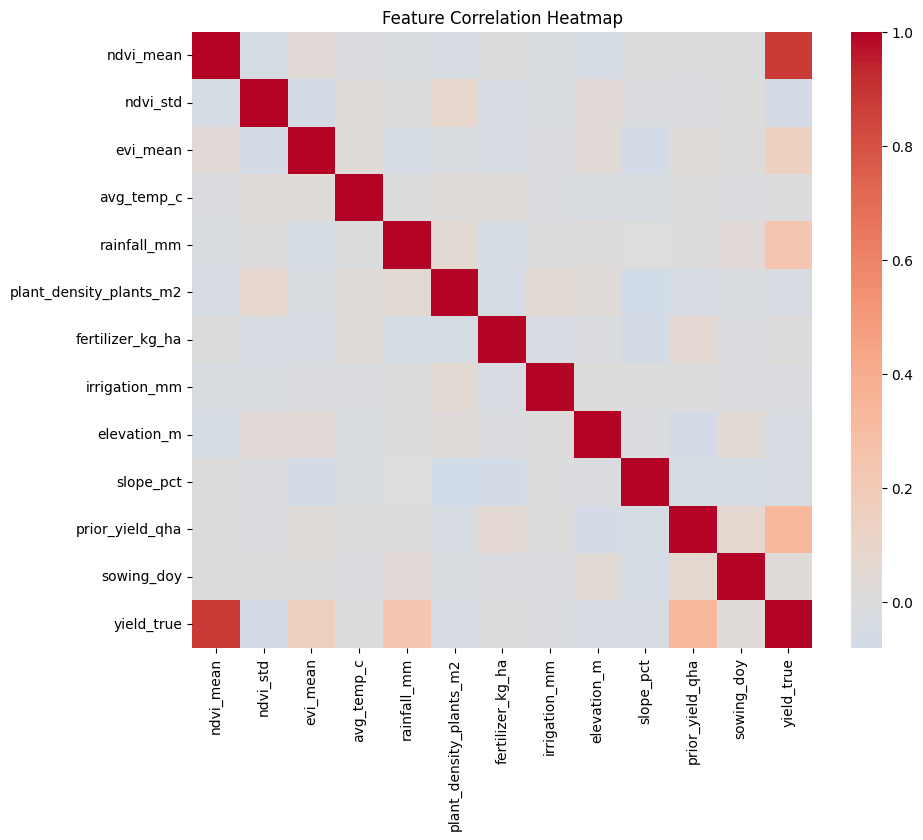

In [2]:
import os, json, math, random, joblib
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt

np.random.seed(123)
M = 1000  # more samples for DL
soil_types = ['loam','clay','sandy']
def rand_cat():
    return random.choice(soil_types)

df2 = pd.DataFrame({
    'ndvi_mean': np.random.uniform(0.2, 0.8, M),
    'ndvi_std': np.random.uniform(0.01, 0.15, M),
    'evi_mean': np.random.uniform(0.15, 0.7, M),
    'avg_temp_c': np.random.uniform(24, 34, M),
    'rainfall_mm': np.random.uniform(150, 400, M),
    'plant_density_plants_m2': np.random.uniform(12, 30, M),
    'fertilizer_kg_ha': np.random.uniform(40, 180, M),
    'irrigation_mm': np.random.uniform(0, 220, M),
    'elevation_m': np.random.uniform(20, 250, M),
    'slope_pct': np.random.uniform(0, 5, M),
    'prior_yield_qha': np.random.uniform(20, 60, M),
    'sowing_doy': np.random.randint(150, 220, M),
    'soil_type': [rand_cat() for _ in range(M)]
})

# Encode soil type
df2 = pd.get_dummies(df2, columns=['soil_type'], drop_first=False)

# Nonlinear synthetic yield function
noise = np.random.normal(0, 1.2, M)
temp_pen = -0.8 * np.abs(df2['avg_temp_c'] - 29)
rain_term = 0.05 * (df2['rainfall_mm'] - 260)
fert_term = 0.06 * np.sqrt(df2['fertilizer_kg_ha'])
irr_term = 0.03 * np.log1p(df2['irrigation_mm'])
topo_pen = -0.1 * (df2['slope_pct']) + 0.02 * (200 - df2['elevation_m'])/200
veg_term = 70*df2['ndvi_mean'] + 10*df2['evi_mean'] - 5*df2['ndvi_std']
carry_term = 0.4 * df2['prior_yield_qha']
sowing_term = -0.05 * np.abs(df2['sowing_doy'] - 180)
soil_bonus = 3*df2.get('soil_type_loam',0) + 0*df2.get('soil_type_clay',0) + (-2)*df2.get('soil_type_sandy',0)

df2['yield_true'] = (veg_term + temp_pen + rain_term + fert_term + irr_term + topo_pen + carry_term + sowing_term + soil_bonus + noise)

# Train/val/test split
from sklearn.model_selection import train_test_split
features = [c for c in df2.columns if c != 'yield_true']
X_train, X_tmp, y_train, y_tmp = train_test_split(df2[features], df2['yield_true'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

# Correlation heatmap (numeric)
plt.figure(figsize=(10,8))
corr = df2.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

In [ ]:
# RandomForest on rich dataset + importance + parity + residuals
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance

rf = RandomForestRegressor(n_estimators=300, random_state=42).fit(X_train, y_train)
pred_val = rf.predict(X_val)
pred_test = rf.predict(X_test)
print('RF R2 (val):', round(r2_score(y_val, pred_val),3), ' MAE(val):', round(mean_absolute_error(y_val, pred_val),2))
print('RF R2 (test):', round(r2_score(y_test, pred_test),3), ' MAE(test):', round(mean_absolute_error(y_test, pred_test),2))

imp = permutation_importance(rf, X_val, y_val, n_repeats=5, random_state=42)
imp_df = pd.DataFrame({'feature': X_val.columns, 'importance': imp.importances_mean}).sort_values('importance', ascending=False).head(15)
plt.figure(figsize=(8,6))
sns.barplot(data=imp_df, x='importance', y='feature', orient='h')
plt.title('Permutation Importance (top 15)')
plt.show()

# Parity
plt.figure(figsize=(5,5))
sns.scatterplot(x=y_val, y=pred_val, s=20, alpha=0.5)
mn, mx = min(y_val.min(), pred_val.min()), max(y_val.max(), pred_val.max())
plt.plot([mn,mx],[mn,mx],'r--')
plt.xlabel('Observed'); plt.ylabel('Predicted'); plt.title('RF Parity (val)')
plt.show()

# Residuals
res = y_val - pred_val
plt.figure(figsize=(6,4))
sns.histplot(res, bins=30, kde=True)
plt.title('RF Residuals (val)')
plt.show()

## Deep Learning (PyTorch MLP, 100 epochs)
We standardize features, train an MLP with early stopping, and save the best model and scaler for serving.

In [ ]:
import torch, torch.nn as nn, torch.optim as optim
from sklearn.preprocessing import StandardScaler

# Ensure models dir
root = os.path.abspath(os.path.join(os.getcwd(), '..')) if os.path.basename(os.getcwd())=='notebooks' else os.getcwd()
models_dir = os.path.join(root, 'models')
os.makedirs(models_dir, exist_ok=True)

# Standardize
scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_val = scaler.transform(X_val)
Xs_test = scaler.transform(X_test)

X_train_t = torch.tensor(Xs_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_val_t = torch.tensor(Xs_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(Xs_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

class MLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

model = MLP(X_train_t.shape[1])
crit = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=1e-3)

best_val = float('inf')
best_path = os.path.join(models_dir, 'best_mlp.pt')
history = {'train_loss':[], 'val_loss':[]}

for epoch in range(1, 101):  # 100 epochs
    model.train()
    opt.zero_grad()
    out = model(X_train_t)
    loss = crit(out, y_train_t)
    loss.backward()
    opt.step()
    model.eval()
    with torch.no_grad():
        vout = model(X_val_t)
        vloss = crit(vout, y_val_t)
    history['train_loss'].append(loss.item())
    history['val_loss'].append(vloss.item())
    if vloss.item() < best_val:
        best_val = vloss.item()
        torch.save(model.state_dict(), best_path)
    if epoch % 10 == 0:
        print(f'Epoch {epoch:03d} train {loss.item():.3f} val {vloss.item():.3f}')

# Load best and evaluate
best = MLP(X_train_t.shape[1])
best.load_state_dict(torch.load(best_path, map_location='cpu'))
best.eval()
with torch.no_grad():
    pred_val_dl = best(X_val_t).squeeze(1).numpy()
    pred_test_dl = best(X_test_t).squeeze(1).numpy()
from sklearn.metrics import r2_score, mean_absolute_error
print('DL R2 (val):', round(r2_score(y_val, pred_val_dl),3), ' MAE(val):', round(mean_absolute_error(y_val, pred_val_dl),2))
print('DL R2 (test):', round(r2_score(y_test, pred_test_dl),3), ' MAE(test):', round(mean_absolute_error(y_test, pred_test_dl),2))

# Loss curves
plt.figure(figsize=(6,4))
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend(); plt.title('MLP Loss Curves')
plt.show()

# Parity plot (DL)
plt.figure(figsize=(5,5))
sns.scatterplot(x=y_val, y=pred_val_dl, s=20, alpha=0.5)
mn, mx = min(y_val.min(), pred_val_dl.min()), max(y_val.max(), pred_val_dl.max())
plt.plot([mn,mx],[mn,mx],'r--')
plt.xlabel('Observed'); plt.ylabel('Predicted'); plt.title('DL Parity (val)')
plt.show()

# Save scaler and feature meta for serving
joblib.dump(scaler, os.path.join(models_dir, 'scaler.joblib'))
meta = {'features': features}
with open(os.path.join(models_dir, 'feature_meta.json'), 'w') as f: json.dump(meta, f)
print('Saved:', best_path)

## Transformer-based tabular model (FT-Transformer)
We treat each feature as a token (continuous features via small linear tokenizers and categorical via embeddings), pass through a Transformer encoder, and regress yield. We save weights and preprocessing for serving.

In [4]:
# Prepare continuous + categorical views for Transformer
# Reconstruct soil_type from one-hot columns and build df3 with original categorical
onehot_cols = [c for c in df2.columns if c.startswith('soil_type_')]
if onehot_cols:
    idx = np.argmax(df2[onehot_cols].values, axis=1)
    vocab = [c.split('soil_type_')[1] for c in onehot_cols]
    df3 = df2.copy()
    df3['soil_type'] = [vocab[i] for i in idx]
    df3 = df3.drop(columns=onehot_cols)
else:
    # Fallback: if one-hots not present, assume df2 has 'soil_type'
    df3 = df2.copy()

cont_cols = [c for c in df3.columns if c not in ['yield_true','soil_type']]
cat_col = 'soil_type'
soil_vocab = sorted(df3[cat_col].unique().tolist())
soil_to_idx = {s:i for i,s in enumerate(soil_vocab)}

from sklearn.model_selection import train_test_split
X_train3, X_tmp3, y_train3, y_tmp3 = train_test_split(df3[cont_cols+[cat_col]], df3['yield_true'], test_size=0.3, random_state=42)
X_val3, X_test3, y_val3, y_test3 = train_test_split(X_tmp3, y_tmp3, test_size=0.5, random_state=42)

from sklearn.preprocessing import StandardScaler
scaler_tab = StandardScaler().fit(X_train3[cont_cols])

import torch
Xc_train = torch.tensor(scaler_tab.transform(X_train3[cont_cols]).astype('float32'))
Xc_val = torch.tensor(scaler_tab.transform(X_val3[cont_cols]).astype('float32'))
Xc_test = torch.tensor(scaler_tab.transform(X_test3[cont_cols]).astype('float32'))
Xcat_train = torch.tensor(X_train3[cat_col].map(soil_to_idx).astype('int64').values)
Xcat_val = torch.tensor(X_val3[cat_col].map(soil_to_idx).astype('int64').values)
Xcat_test = torch.tensor(X_test3[cat_col].map(soil_to_idx).astype('int64').values)
y_train_t2 = torch.tensor(y_train3.values.astype('float32')).unsqueeze(1)
y_val_t2 = torch.tensor(y_val3.values.astype('float32')).unsqueeze(1)
y_test_t2 = torch.tensor(y_test3.values.astype('float32')).unsqueeze(1)

In [5]:
# FT-Transformer model
import torch.nn as nn

class FeatureTokenizer(nn.Module):
    def __init__(self, n_cont, d_model):
        super().__init__()
        # one linear per continuous feature -> token dim d_model
        self.linears = nn.ModuleList([nn.Linear(1, d_model) for _ in range(n_cont)])
    def forward(self, x):
        # x: [B, n_cont]
        tokens = []
        for j, lin in enumerate(self.linears):
            tok = lin(x[:, j:j+1])  # [B, d_model]
            tokens.append(tok)
        return torch.stack(tokens, dim=1)  # [B, n_cont, d_model]

class FTTransformer(nn.Module):
    def __init__(self, n_cont, n_cat, d_model=64, nhead=4, nlayers=2, dropout=0.1):
        super().__init__()
        self.cls = nn.Parameter(torch.randn(1,1,d_model))
        self.cont_tok = FeatureTokenizer(n_cont, d_model)
        self.cat_emb = nn.Embedding(n_cat, d_model)
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=256, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=nlayers)
        self.head = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, 1))
    def forward(self, x_cont, x_cat):
        B = x_cont.size(0)
        cont_tokens = self.cont_tok(x_cont)           # [B, n_cont, d_model]
        cat_token = self.cat_emb(x_cat).unsqueeze(1)  # [B, 1, d_model]
        tokens = torch.cat([cont_tokens, cat_token], dim=1) # [B, n_cont+1, d_model]
        cls = self.cls.expand(B, -1, -1)
        seq = torch.cat([cls, tokens], dim=1)         # [B, n_tokens+1, d_model]
        enc = self.encoder(seq)                       # [B, T, d_model]
        cls_out = enc[:,0,:]
        return self.head(cls_out)

n_cont = len(cont_cols)
n_cat = len(soil_vocab)
ft = FTTransformer(n_cont, n_cat)
crit2 = nn.MSELoss()
opt2 = torch.optim.Adam(ft.parameters(), lr=1e-3)

best_val2 = float('inf')
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..')) if os.path.basename(os.getcwd())=='notebooks' else os.getcwd()
models_dir = os.path.join(root_dir, 'models')
os.makedirs(models_dir, exist_ok=True)
ft_path = os.path.join(models_dir, 'best_tabtransformer.pt')
meta_path = os.path.join(models_dir, 'tab_meta.json')
scaler_path = os.path.join(models_dir, 'tab_scaler.joblib')

hist2 = {'train':[], 'val':[]}
for epoch in range(1, 101):
    ft.train(); opt2.zero_grad()
    pred = ft(Xc_train, Xcat_train)
    loss = crit2(pred, y_train_t2)
    loss.backward(); opt2.step()
    ft.eval();
    with torch.no_grad():
        vpred = ft(Xc_val, Xcat_val)
        vloss = crit2(vpred, y_val_t2)
    hist2['train'].append(loss.item()); hist2['val'].append(vloss.item())
    if vloss.item() < best_val2:
        best_val2 = vloss.item()
        torch.save(ft.state_dict(), ft_path)
    if epoch % 10 == 0:
        print(f'[FT] Epoch {epoch:03d} train {loss.item():.3f} val {vloss.item():.3f}')

# Evaluate best
ft_best = FTTransformer(n_cont, n_cat)
ft_best.load_state_dict(torch.load(ft_path, map_location='cpu'))
ft_best.eval()
with torch.no_grad():
    vpred = ft_best(Xc_val, Xcat_val).squeeze(1).numpy()
    tpred = ft_best(Xc_test, Xcat_test).squeeze(1).numpy()
from sklearn.metrics import r2_score, mean_absolute_error
print('FT R2 (val):', round(r2_score(y_val3, vpred),3), ' MAE(val):', round(mean_absolute_error(y_val3, vpred),2))
print('FT R2 (test):', round(r2_score(y_test3, tpred),3), ' MAE(test):', round(mean_absolute_error(y_test3, tpred),2))

# Save preprocessing and meta
import joblib, json
joblib.dump(scaler_tab, scaler_path)
with open(meta_path, 'w') as f:
    json.dump({'cont_cols': cont_cols, 'cat_col': cat_col, 'soil_vocab': soil_vocab}, f)
print('Saved:', ft_path, scaler_path, meta_path)

[FT] Epoch 010 train 2615.058 val 2507.487
[FT] Epoch 020 train 2539.313 val 2438.526
[FT] Epoch 020 train 2539.313 val 2438.526
[FT] Epoch 030 train 2469.179 val 2370.002
[FT] Epoch 030 train 2469.179 val 2370.002
[FT] Epoch 040 train 2399.325 val 2300.880
[FT] Epoch 040 train 2399.325 val 2300.880
[FT] Epoch 050 train 2326.128 val 2228.907
[FT] Epoch 050 train 2326.128 val 2228.907
[FT] Epoch 060 train 2249.738 val 2154.010
[FT] Epoch 060 train 2249.738 val 2154.010
[FT] Epoch 070 train 2170.856 val 2076.395
[FT] Epoch 070 train 2170.856 val 2076.395
[FT] Epoch 080 train 2089.080 val 1996.252
[FT] Epoch 080 train 2089.080 val 1996.252
[FT] Epoch 090 train 2004.630 val 1913.981
[FT] Epoch 090 train 2004.630 val 1913.981
[FT] Epoch 100 train 1918.882 val 1829.962
FT R2 (val): -8.59  MAE(val): 40.49
FT R2 (test): -9.756  MAE(test): 40.24
Saved: c:\workspace\yes-scan-apex\yes_scan_prototype\models\best_tabtransformer.pt c:\workspace\yes-scan-apex\yes_scan_prototype\models\tab_scaler.jobl